<h1>Stars of mitigation? Participation-based structures and performance in a city-to-business network </h1>
<h2> Milja Heikkinen, Onerva Korhonen, Sirkku Juhola, & Tuomas Ylä-Anttila, 2021</h2>

In the related article, we investigate Climate Partners (CP), a city-to-business network coordinated by the city of Helsinki, as a case example of the role of city-to-business networks in climate change mitigation. We study the performance of the CP in terms of bipartite graph analysis as well as with a quantitative performance index. This frontend notebook walks the reader through the bipartite graph analysis. For any details of the methodology, please see the Materials and Methods section of the article.

The easiest way to execute the notebook is via Binder. Cells of the notebook often depend on the previous ones, so always execute cells in order. The versions used are Python 2.7, Numpy 1.14.0, NetworkX 2.1, Scipy 1.0.0, and Matplotlib 2.1.2.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/onerva-korhonen/climate-companions-bipartite/HEAD)

<b>NOTE:</b> For privacy reasons, we are unfortunately not allowed to share the original Climate Partners event and participant data publicly. Therefore, <b> the data used for running this notebook is simulated</b>, although it approximately matches the properties of the original CP data. Because of this, the results produced by running this notebook differ from those reported in the article. 

In case of questions about the article or the original data, please contact Milja Heikkinen (milja.e.heikkinen@gmail.com). In case of questions about the code, please contact Onerva Korhonen (onerva.korhonen@gmail.com).

Let's start by some imports. <code>parameters</code> is a storage file for all parameters used in the analysis. <code>functions</code> contains all functions used to run the analysis. In this frontend notebook, <code>numpy</code> is used for minor operations, for example calculating averages. All remaining imports are done inside the <code>functions</code> file.

In [1]:
import parameters as pms
import functions

import numpy as np

Parameters are passed to analysis functions inside a dictionary called <code>cfg</code>, defined in the following cell. For details on the different parameters, see the documentation in <code>functions</code>.

In [13]:
cfg = {}

# parameters for reading data
cfg['companyInputPath'] = 'walkthrough_data/company_input_file.csv'
cfg['eventInputPath'] = 'walkthrough_data/event_input_file.csv'
cfg['linkInputPath'] = 'walkthrough_data/link_input_file.csv'
cfg['companyColumnNames'] = ['Alias:', 'Member:', 'Index:', 'Max degree:'] # this is set manually to match the example data; it could be set through pms.companyColumnNames
cfg['eventColumnNames'] = pms.eventColumnNames
cfg['linkColumnNames'] = pms.linkColumnNames
cfg['tags'] = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','HKI_1','HKI_2'] # this is set manually to match the example data; it could be set through pms.tags
cfg['classes'] = pms.membershipClasses
cfg['csvSeparator'] = pms.csvSeparator
cfg['indexKey'] = pms.indexKey
cfg['degreeNormalizationKey'] = pms.degreeNormalizationKey
    
# parameters related to including/excluding participants in/from analysis
cfg['ignoreNonMembers'] = pms.ignoreNonMembers
cfg['nonMemberClasses'] = pms.nonMemberClasses
cfg['separateClasses'] = pms.separateClasses
cfg['normalizeDegreeInScatter'] = pms.normalizeDegreeInScatter
cfg['nodesToExcludeFromScatter'] = ['HKI_1','HKI_2'] # this is set manually to match the example data; it could be set through pms.nodesToExcludeFromScatter
cfg['eventColumnNames'] = pms.eventColumnNames
    
# parameters related to null models
cfg['nRandomIterations'] = pms.nRandomIterations
cfg['fieldMeanDegreesSigLimit'] = pms.fieldMeanDegreesSigLimit
    
# visualization parameters
cfg['topColor'] = pms.topColor
cfg['bottomColor'] = pms.bottomColor
cfg['classColors'] = pms.classColors
cfg['networkColors'] = pms.networkColors
cfg['nonUniqueColorTags'] = pms.nonUniqueColorTags
cfg['networkNonUniqueColor'] = pms.networkNonUniqueColor
cfg['networkBottomColor'] = pms.networkBottomColor
cfg['nodeSize'] = pms.nodeSize
cfg['nodeShapes'] = pms.nodeShapes
cfg['bottomShape'] = pms.bottomShape
cfg['edgeWidth'] = pms.edgeWidth
cfg['edgeAlpha'] = pms.edgeAlpha
cfg['scatterMarker'] = pms.scatterMarker
cfg['classMarkers'] = pms.classMarkers
cfg['markerAlpha'] = pms.markerAlpha
cfg['randomColor'] = pms.randomColor
cfg['randomAlpha'] = pms.randomAlpha
cfg['dataColor'] = pms.dataColor
cfg['dataLineWidth'] = pms.dataLineWidth
cfg['fieldHistWidth'] = pms.fieldHistWidth
cfg['indexPercentile'] = pms.indexPercentile
cfg['indexPercentileLineStyle'] = pms.indexPercentileLineStyle
cfg['indexPercentileColor'] = pms.indexPercentileColor
cfg['indexPercentileAlpha'] = pms.indexPercentileAlpha

In the CP bipartite graphs, top nodes represent event participants, bottom nodes correspond to events, and links connect participants to those events they participated in. The data needed for constructing the network is stored in three <code>.csv</code> files: the company input file located at <code>cfg['companyInputPath']</code> contains information about the participants, including their name, alias, membership class, and field of business, the event input file located at <code>cfg['eventInputPath']</code> contains information about the events, and the link input file at <code>cfg['linkInputPath']</code> contains the participant - event pairs. These paths can be specified in the <code>params</code> file or given directly in the frontend script.

In the article, we use four two-year time windows: 2011-2012, 2013-2014, 2015-2016, and 2017-2018. Further, we analysed also the whole period 2011-2018 as a single eight-year window. In this case, the company and event input files contained information about all participants and events and were thus used for all time windows, while the link input files were time-window specific.

Most of the graph analysis of the article take place inside a for loop over time windows and corresponding link input files. In this frontend notebook, we will demonstrate the main analysis steps for a single time window.

We begin by calculating some basic properties of the CP bipartite graph. The results produced by the following cell are reported in Table 2 of the article and discussed in detail in section 3.

In [23]:
nodesToExcludeFromDegrees = pms.nodesToExcludeFromDegrees # this is for excluding the instances of the city of Helsinki from the mean degree calculations

mclasses = list(cfg['classes']) # these are the membership classes listed in the parameters file
for nonMemberClass in cfg['nonMemberClasses']:
    mclasses.remove(nonMemberClass)
    
bnet = functions.createBipartite(cfg) # this creates the bipartite graph based on event participation
    
top,_ = functions.getTopAndBottom(bnet) # top nodes correspond to the participants
tlist = list(top)
nodeClasses = [bnet.nodes(data=True)[node]['class'] for node in tlist]
degrees = [bnet.degree(node) for node in tlist] # this gives the degrees, that is, numbers of events participated, of the top nodes
    
for mclass in mclasses:
    # counting the number of CP members that participate or did not participate in events
    # in case of multiple time windows, this loop can be tuned to count only participation inside the present window
    # for details, see frontend.py
    partCount = 0
    nonpartCount = 0
    for nodeClass,degree in zip(nodeClasses,degrees):
        if nodeClass == mclass:
            if degree > 0:
                partCount += 1
            else:
                nonpartCount += 1
        
    print 'In class ' + mclass + ' ' + str(partCount) + ' participants, ' + str(nonpartCount) + ' non-participants'
        
# counting the number of participants that were not CP members
partCount = 0
        
for nodeClass,degree in zip(nodeClasses,degrees):
    if nodeClass in cfg['nonMemberClasses'] and degree > 0:
        partCount += 1
        
nonMemberStr = ', '.join(cfg['nonMemberClasses'])
print 'In classes ' + nonMemberStr + ' ' + str(partCount) + ' participants'
                
# calculating the graph density with and without nonmember participants
            
bnet, nZeroDegree = functions.pruneBipartite(bnet) # this removes from the graph all nodes that have degree 0
        
density = functions.getDensity(bnet)
densityWithoutNonMembers = functions.getDensity(bnet,excludeNonMembers=True,nonMemberClasses=cfg['nonMemberClasses'])
print 'Density: ' + str(density) + ', ' + str(densityWithoutNonMembers) + ' excluding non-members'
     
top,bottom = functions.getTopAndBottom(bnet) # the top and bottom nodes correspond to participants and events
        
# calculating the number of events and participants/event and events/participant
        
print str(len(bottom)) + ' events organized'
        
cnet = bnet.copy() # calculating the events/participant and participants/event requires excluding some nodes, so let's use a copy of the network
for node in top:
    if node in nodesToExcludeFromDegrees: # first removing only the nodes particularly listed for being removed (in our case, the instances of the city of Helsinki that participate in all events and articially increase the mean participants/event)
        cnet.remove_node(node)
        
ctop, cbottom = functions.getTopAndBottom(cnet) # we need to obtain the top and bottom again after removing some nodes
bottomDegrees = [cnet.degree(node) for node in cbottom]
print 'On average ' + str(np.mean(bottomDegrees)) + ' participants per event, min ' + str(min(bottomDegrees)) + ', max ' + str(max(bottomDegrees))
        
for node in ctop:
    if cnet.nodes(data=True)[node]['class'] in cfg['nonMemberClasses']: # now, removing all non-member nodes (that often participate only one event, thus artificially lowering mean events/participant)
        cnet.remove_node(node)
        
ctop,_ = functions.getTopAndBottom(cnet)
topDegrees = [cnet.degree(node) for node in ctop]
print 'On average ' + str(np.mean(topDegrees)) + ' events per participant, min ' + str(min(topDegrees)) + ', max ' + str(max(topDegrees))

In class BM 69 participants, 6 non-participants
In class OM 16 participants, 1 non-participants
In classes NM, HKI 119 participants
Density: 0.145424836601, 0.239215686275 excluding non-members
18 events organized
On average 27.833333333333332 participants per event, min 8, max 56
On average 4.305882352941176 events per participant, min 1, max 14


In the article, we investigate the participant turnover between time windows in terms of Jaccard index. In order to calculate the Jaccard indices, top nodes, that is, participants of each time window need to be appended into the <code>topNodes</code> and <code>topNodesWithoutNonmembers</code> lists; the later should contain only participants that are CP members. Then, the code in the following cell enables calculating the Jaccard indices (the <code>years</code> parameter refers to <code>pms.years</code>). The Jaccard indices are reported in supplementary table S2 and discussed in section 3 of the article.

In [4]:
# the following code is commented out because running it would require first looping over time windows

#jaccards = []
#jaccardsWithoutNonmembers = []
        
#for i in range(len(years)-1):
#    jaccard = functions.getJaccardIndex(topNodes[i],topNodes[i+1])
#    jaccards.append(jaccard)
#    jaccardWithoutNonmembers = functions.getJaccardIndex(topNodesWithoutNonmembers[i],topNodesWithoutNonmembers[i+1])
#    jaccardsWithoutNonmembers.append(jaccardWithoutNonmembers)
#    print 'Jaccard index, years ' + years[i] + ', ' + years[i+1] + ': ' + str(jaccard) + ', without non-members ' + str(jaccardWithoutNonmembers)

We continue by visualizing the network, first with all nodes and then excluding the nodes representing non-member participants (Fig. 1 of the article). In both cases, the visualization is characterized by star-like structures where participants participate in single events only. We discuss this in detail in chapter 3.1 of the article.

In these visualizations, node shape indicates membership class (black circle: event, colored circle: CP business member, square: CP other member, diamond: non-member participant, triangle: city of Helsinki instance) and node color the field of business. Note that the fields of business of the example data are arbitrary so the colors used here do not match those of Fig. 1 of the article.

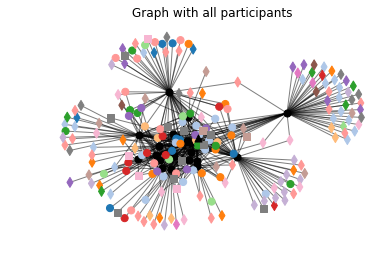

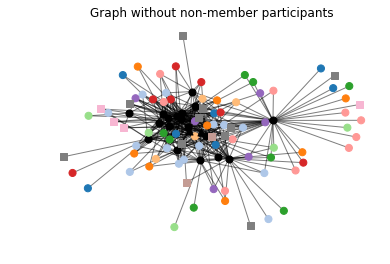

In [16]:
cfg['skipNonMembersInVisualization'] = False
functions.drawNetwork(bnet,cfg)
cfg['skipNonMembersInVisualization'] = True
functions.drawNetwork(bnet,cfg) # repeat network drawing without non-member nodes

The next analysis steps concentrate on graph cliques, that is, participants that co-participated a certain set of events. For details about clique detection, see section 2.5.2 of the article and supplementary text S1.

In [17]:
cliques, cliqueInfo = functions.findBicliques(bnet)

We evaluate the engagement of CP members in terms of graph starness or the fraction of CP members participating in a single event only. Before calculating the starness, we remove from the graph all non-member participants since they often participate in one event only and would therefore artificially increase starness. The starness value confirms that the CP faces problems engaging members in network activities; for a detailed discussion, see section 3.1 of the article.

In [18]:
cfg['nonMemberClasses'] = pms.nonMemberClassesForStarness
starnessCliques, starnessCliqueInfo = functions.pruneStars(bnet,cliques,cliqueInfo,ignoreNonMembers=cfg['ignoreNonMembers'],nonMemberClasses=cfg['nonMemberClasses']) # this removes from the stars all non-members as well as participants that participated in more than one event
starness = functions.getStarness(bnet,cliqueInfo,ignoreNonMembers=cfg['ignoreNonMembers'],nonMemberClasses=cfg['nonMemberClasses'])
print 'Starness: ' + str(starness)

Starness: 0.247058823529


To evaluate the significance of the obtained starness value, we compare it to the starness distribution obtained from 1 000 null model graphs (for details, see section 2.5.5.1 of the article). The <code>compareAgainstRandom</code> function called in the following cell loops over the null model graphs. Therefore, executing the cell may take some minutes.

We compare the obtained starness to the mean starness of the null model graphs in terms of one-sample t test. In addition to the t and p values, the <code>compareAgainstRandom</code> function plots the cumulative degree distribution functions, showing that the CP graph contains more low and high degree nodes and less nodes of middle degree than the null model graphs (Fig. 2 of the article). Besides, it computes the average degree of participants from different fields of business and compares these averages to those obtained from the null model graphs (Fig. 3 of the article). For a detailed discussion of these results, see section 3.1 of the article.

Starness of random networks, mean: 0.04027370711543615, true starness: 0.247058823529
t: -336.29263372752547, p: 0.0


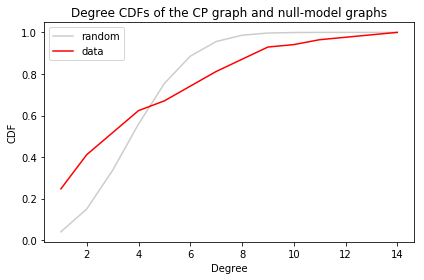

For field A, t = -11.291282274149024, p = 6.552397469720103e-28, considered significant at Bonferroni corrected level 0.000833333333333

For field C, t = 11.89238121533616, p = 1.3480991932833068e-30, considered significant at Bonferroni corrected level 0.000833333333333

For field B, t = -88.68072043526328, p = 0.0, considered significant at Bonferroni corrected level 0.000833333333333

For field E, t = 31.196463947039305, p = 1.0181376236948033e-149, considered significant at Bonferroni corrected level 0.000833333333333

For field D, t = -104.59391555158048, p = 0.0, considered significant at Bonferroni corrected level 0.000833333333333

For field G, t = -4.286907970740508, p = 1.9872332842038472e-05, considered significant at Bonferroni corrected level 0.000833333333333

For field F, t = 62.72846560579025, p = 0.0, considered significant at Bonferroni corrected level 0.000833333333333

For field I, t = -15.149280032471328, p = 8.024598850477911e-47, considered significant at Bonferr

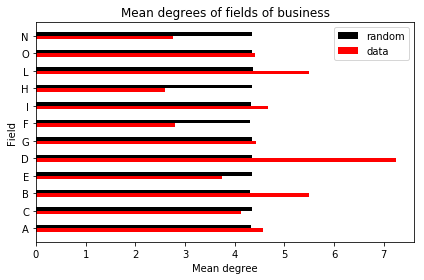

In [19]:
measures = {'starness':starness}        
functions.compareAgainstRandom(bnet,cfg,measures)

Next, we investigate if the CP manages to bring together companies from different fields. To this end, we calculate three measures of biclique diversity: richness, effective diversity, and relative diversity (for details, see section 2.5.4 of the article). Before the diversity analysis, we need to re-run the biclique detection algorithm to include also the nodes removed from the starness analysis.

In [20]:
cliques, cliqueInfo = functions.findBicliques(bnet)
richnesses, diversities, counts, majorFields = functions.getCliqueFieldDiversityWrapper(bnet,cliqueInfo)

Again, we use the null model graphs to evaluate the significance of the observed diversity values (for details of the null model graphs, see section 2.5.5.2 of the article). The diversity values show that CP succesfully brings together participants from different fields of business (for a detailed discussion on the diversity values and their significance see section 3.2 of the article).

Similarly as above, the <code>compareAgainstRandom</code> function generates 1 000 null model graphs. Therefore, executing the following cell may take some minutes.

The <code>compareAgainstRandom</code> function features an option for creating a set of visualizations related to diversity. In order to show them, set the <code>plotPDFs</code> parameter to <code>True</code>. Note that these visualizations are not included in the article.

In [21]:
measures = {'richness':richnesses,'diversity':diversities, 'cliques':cliques}
functions.compareAgainstRandom(bnet,cfg,measures,plotPDFs=False)

Mean richness of random networks, pooled: 5.459572710951527, true mean richness: 6.1813285457809695
t: -56.496464828347634, p: 2.53553126724e-313
Mean effective diversity of random networks, pooled: 4.786005337260864, true mean effective diversity: 5.656869157856037
t: -55.53290793678337, p: 1.1660340691981773e-307
Mean relative diversity of random networks, pooled: 0.892668866992155, true mean relative diversity: 0.9308404069304672
t: -42.772109740282055, p: 5.378361207745419e-228


Finally, we address the question about the self-reported performance of CP members: does high performance correlate with active event participation? To this end, we plot the values of a qualitative performance index of all CP members against their degree, that is, the number of events they participated in. Note that by default, degree is normalized by the total number of events; for plotting unnormalized degree, set <code>cfg['normalizeDegreeInScatter']</code> to <code>False</code>.

By default, this analysis does not include the non-member participants, since they lack the performance index value. Further, it is possible to exclude nodes using the <code>cfg['nodesToExcludeFromScatter']</code> parameter, as we have done for instance of the city of Helsinki (and in the article also for one outlier node that participated numerous events before joining the CP).

For executing the following cell, the index values need to be included in the company input file. For a detailed description and discussion of the index, see sections 2.6 and 3.3 of the article.

In addition to creating the scatter (Fig. 4 of the article), the <code>createDegreeIndexScatter</code> function calculates the Pearson correlation coefficient between degree and the performance index. For business members, there is a moderate correlation between participation activity and self-reported performance, while such a correlation is not present for other members. We discuss these results in section 3.4 of the article.

Similarly as in the network visualization, the shape and color of data points indicate membership class (circle: business member, square: other member) and field of business. The dashed line shows the performance index value of 50%. The legend is removed from the visualization below as it shadows some of the points. To show the legend, set <code>show_legend</code> to <code>True</code>.

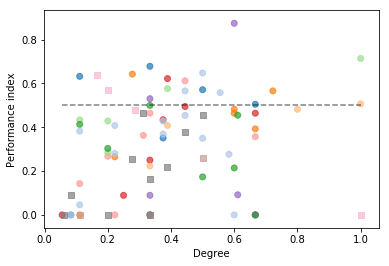

In [22]:
functions.createDegreeIndexScatter(bnet, cfg, show_legend=False)